In [123]:
import torch as pt
import torchvision as tv
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt

In [124]:
data = np.load('full_mnist.npz')
X, y = data['X'], data['y']

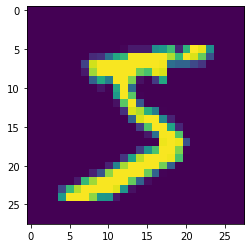

In [125]:
plt.imshow(X[0]);

In [126]:
class CNN(pt.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = pt.nn.Sequential(
        pt.nn.Conv2d(1, 30, 3),
        pt.nn.MaxPool2d(2),
        pt.nn.ReLU(),
        pt.nn.Conv2d(30, 30, 3),
        pt.nn.MaxPool2d(2),
        pt.nn.ReLU(),
        pt.nn.Conv2d(30, 15, 3),
        pt.nn.MaxPool2d(2),
        pt.nn.ReLU(),
        pt.nn.Flatten(),
        pt.nn.Linear(15, 64),
        pt.nn.ReLU(),
        pt.nn.Linear(64, 10),
        pt.nn.Softmax()
        )
    
    def predict(self, X):
        return self.model(X)


model = CNN()
optim = pt.optim.Adam(model.parameters())
loss = pt.nn.CrossEntropyLoss()

In [133]:
X_correct = pt.Tensor(X).unsqueeze(1)

In [127]:
y_correct_dtype = pt.Tensor(y).long()

In [128]:
data_loader = pt.utils.data.DataLoader(pt.utils.data.TensorDataset(pt.Tensor(X).unsqueeze(1), y_correct_dtype), batch_size=32)

In [130]:

for Xt, yt in tqdm.tqdm(data_loader):
    optim.zero_grad()
    yp = model.predict(Xt)
    L = loss(yp, yt.long())
    L.backward()
    optim.step()

100%|██████████| 1875/1875 [00:34<00:00, 54.06it/s]


/Volumes/Storage/goinfre/ptyshevs/env/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


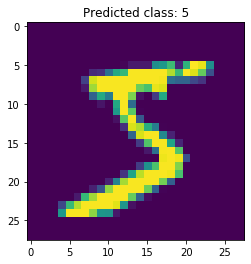

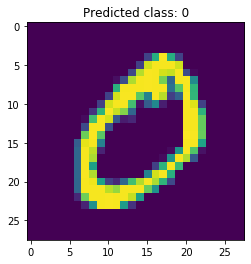

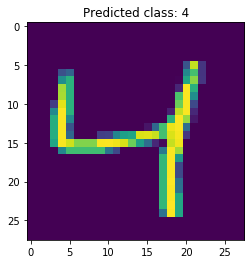

In [144]:
top_n = 3
first_ten_y_pred = model.predict(X_correct[:top_n]).argmax(1)
for i in range(top_n):
    x = X_correct[i].squeeze()
    plt.imshow(x)
    plt.title(f'Predicted class: {first_ten_y_pred[i]}');
    plt.show()

In [145]:
adv_target = 0

In [172]:
def fitness(X):
    """ X - np.array"""
    y = model.predict(pt.Tensor(X).unsqueeze(0).unsqueeze(1))
    return y[:, adv_target].mean().item()

In [185]:
class GeneticSolver:
    def __init__(self, population_size=30, n_generations=1000, retain_best=0.8, retain_random=0.05, mutate_chance=0.05,
                 verbosity=0, verbosity_step=50, random_state=-1, warm_start=False, early_stopping=True, patience=20,
                 initialization_strategy='uniform', fitness_parallel=False):
        """
        :param population_size: number of individual candidate solutions
        :param n_generations: number of generations
        :param retain_best: percentage of best candidates to select into the next generation
        :param retain_random: probability of selecting sub-optimal candidate into the next generation
        :param mutate_chance: candidate mutation chance
        :param verbosity: level of verbosity (0 - quiet, 1 - evolution information, 2 - spamming like it's 2003)
        :param verbosity_step: number of generations to process before showing the best score
        :param random_state: if specified, initializes seed with this value
        :param warm_start: if True, initial population generation step is omitted, allowing for continuing training
        :param early_stopping: if True, evolution will stop if top-10 candidates are not changing for several generations
        :param patience: number of generations to wait for best solution change when <early_stopping>
        :param initialization_strategy: initial population generation rule: 'uniform' or 'covering'
        :param fitness_parallel: if True, scoring is performed on multiple cores, greatly improving the performance.
                                 Don't use with MPGeneticSolver! (results in deadlock)
        """
        self.population_size = population_size
        self.n_generations = n_generations
        self.retain_best = retain_best
        self.retain_random = retain_random
        self.mutate_chance = mutate_chance
        self.verbosity = verbosity
        self.verbosity_step = verbosity_step
        self.random_state = random_state
        self.warm_start = warm_start
        self.early_stopping = early_stopping
        self.patience = patience
        self.initialization_strategy = initialization_strategy
        self.fitness_parallel = fitness_parallel
        if fitness_parallel:
            self.pool = mp.Pool(mp.cpu_count())
        else:
            self.pool = None

        self._population = None
        if random_state != -1:
            np.random.seed(random_state)

    def solve(self, n_generations=-1):
        """
        :param Y: 20x20 array that represents field in stopping condition
        :param delta: number of steps to revert
        :param n_generations: number of evolution generations. Overrides initialization value if specified
        :return: 20x20 array that represents the best start field found and associated fitness value
        """
        if not (self._population and self.warm_start):
            self._population = self._generate_population()
        if n_generations != -1:
            self.n_generations = n_generations
        scores = np.zeros(len(self._population))
        prev_scores = np.zeros(len(self._population))
        cnt_no_change_in_scores = 0
        for generation in range(self.n_generations):
            self._population, scores = self.evolve()
            if np.isclose(prev_scores[:10], scores[:10]).all():
                cnt_no_change_in_scores += 1
            else:
                cnt_no_change_in_scores = 0
                prev_scores = scores
            if self.verbosity and generation % self.verbosity_step == 0:
                if generation == 0:
                    print("Generation #: best score")
                else:
                    print("Generation ",generation,": ",scores[0])
            if np.isclose(scores[:10], 1).any() or (self.early_stopping and cnt_no_change_in_scores >= self.patience):
                if self.verbosity:
                    print("Early stopping on generation ",generation, " with best score ", scores[0])
                break
        return self._population[0], scores[0]

    def _generate_population(self):
        """
        Generating initial population of individual solutions
        Regardless of strategy, we make 5 initial "warming" steps to make distribution closer to the problem.
        Strategies description:
            * Uniform: each cell has equal probability of being initialized as alive or dead. This will introduce no
                       prior information at all
            * Covering: Each individual is generated with it's own probability of having each cell 'alive'. This gives
                       on average higher initial fitness score, but has no observed effect on long-term behavior
        :return: initial population as a list of 20x20 arrays
        """
        if type(self.initialization_strategy) is str:
            if self.initialization_strategy == 'uniform':
                initial_states = np.random.randint(0, 255, size=(self.population_size, 28, 28))
                return initial_states

    def evolve(self):
        """
        Evolution step
        :param Y: 20x20 array that represents field in stopping condition
        :param delta: number of steps to revert
        :return: new generation of the same size along with scores of the best retained individuals
        """
        if self.fitness_parallel:
          scores = np.array(self.parallel_score_population(self._population))
        else:
          scores = np.array(self.score_population(self._population))
        retain_len = int(len(scores) * self.retain_best)
        sorted_indices = np.argsort(scores)[::-1]
        self._population = [self._population[idx] for idx in sorted_indices]
        best_scores = scores[sorted_indices][:retain_len]
        if self.verbosity > 1:
            print("best scores:", best_scores)
        parents = self._population[:retain_len]
        leftovers = self._population[retain_len:]

        cnt_degenerate = 0
        for gene in leftovers:
            if np.random.rand() < self.retain_random:
                cnt_degenerate += 1
                parents.append(gene)
        if self.verbosity > 1:
            print("# of degenerates left: ", cnt_degenerate)

        cnt_mutations = 0
        for gene in parents[1:]:  # mutate everyone expecting for the best candidate
            if np.random.rand() < self.mutate_chance:
                self.mutate(gene)
                cnt_mutations += 1
        if self.verbosity > 1:
            print("# of mutations: ", cnt_mutations)

        places_left = self.population_size - retain_len
        children = []
        while len(children) < places_left:
            mom_idx, dad_idx = np.random.randint(0, retain_len - 1, 2)
            if mom_idx != dad_idx:
                child1, child2 = self.crossover(parents[mom_idx], parents[dad_idx])
                children.append(child1)
                if len(children) < places_left:
                    children.append(child2)
        if self.verbosity > 1:
            print("# of children: ", len(children))
        parents.extend(children)
        return parents, best_scores

    @classmethod
    def crossover(cls, mom, dad):
        """
        Take two parents, return two children, interchanging half of the allels of each parent randomly
        """
        # select_mask = np.random.randint(0, 2, size=(20, 20), dtype='bool')
        select_mask = np.random.binomial(1, 0.5, size=(28, 28)).astype('bool')
        child1, child2 = np.copy(mom), np.copy(dad)
        child1[select_mask] = dad[select_mask]
        child2[select_mask] = mom[select_mask]
        return child1, child2

    @classmethod
    def mutate(cls, field):
        """
        Inplace mutation of the provided field
        """
        a = np.random.binomial(1, 0.1, size=(28, 28)).astype('bool')
        field[a] = np.clip(field[a] + np.random.randn(*field[a].shape), 0, 255)
        return field

    @classmethod
    def fitness(cls, start_field, end_field, delta):
        """
        Calculate fitness for particular candidate (start configuration of the field)
        Currently unused, as fitness scoring was implemented directly into Cython `life` module.
        :param start_field: candidate (start configuration)
        :param end_field: target (stop configuration)
        :param delta: number of steps to proceed before comparing to stop configuration
        :return: value in range [0, 1] that indicates fractions of cells that match their state
        """
        candidate = life.make_move(start_field, moves=delta)
        return (candidate == end_field).sum() / 400

      
    @classmethod
    def score_population(cls, population):
        """
        Apply fitness function for each gene in a population
        :param population: list of candidate solutions
        :param Y: 20x20 array that represents field in stopping condition
        :param delta: number of steps to revert
        :return: list of scores for each solution
        """
        return [fitness(gene) for gene in population]

    def parallel_score_population(self, population):
        """
        Apply fitness function for each gene in a population in parallel
        :param population: list of candidate solutions
        :param Y: 20x20 array that represents field in stopping condition
        :param delta: number of steps to revert
        :return: list of scores for each solution
        """
        return self.pool.map(partial(parallel_fitness), population)

In [186]:
m = GeneticSolver(verbosity=True, verbosity_step=1)

In [193]:
res, score = m.solve()

Generation #: best score
Generation  1 :  0.9999862909317017
Generation  2 :  0.9999982118606567
Early stopping on generation  2  with best score  0.9999982118606567


In [199]:
y_pred = model.predict(pt.Tensor(res).unsqueeze(0).unsqueeze(1))

In [210]:
y_pred

tensor([[1.0000e+00, 4.5259e-09, 8.4924e-07, 7.8678e-14, 2.6959e-07, 1.1620e-09,
         6.9939e-07, 3.6926e-08, 1.8043e-09, 1.4398e-10]],
       grad_fn=<SoftmaxBackward>)

In [204]:
zero_prob = y_pred[0][0].item()

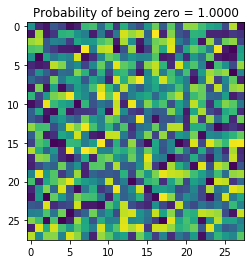

In [209]:
plt.imshow(res);
plt.title(f"Probability of being zero = {zero_prob:.4f}");